In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

np.random.seed(0)


# Predictive Linear Regression

Brandon Martin-Anderson June 2019, with great debt to Moses Marsh, Matt Drury

### Learning goals

- Describe the essential aspects of a prediction task.
- Why estimate?
- How do we test a model?
- Fit a linear model and evaluate its performance with and without `sklearn`.
- Use multiple features, categorical features, and engineered features.
- Pick polynomial regression order using cross-validation.

### The task of predicting quantities: in story form

Let's start a business: **we estimate the fuel economy of cars.** People describe a car and pay us money, and we tell them the fuel economy (in miles per gallon) of their car.

- The first customer comes in, and says, "This is a very competitive field. Why should we pay you?"
- You say, "We are very good at what we do."
- They say, "Your competitor says the same thing. Do you have evidence?"

Note two things.

1. **You are competing against other models.**
2. **Your model will be evaluated quantitatively.**

So you say: "We have analyzed all of our competitors's predictions. All their predictions have some error; the mean of their predictive errors is 5 mpg. We can do better."

- Them: "Ah, interesting. Prove it."
- You: "Describe a car."
- Them: "A 2020 hybrid Ford F250"
- You: "Can't predict - that **that car isn't in our records**"
- Them: "What good is that?"
- You: "If you ask about an old car, we can predict it perfectly."
- Them: "And...why would we pay for that?"
- You: "I don't know, but we are perfect."
- Them: "We'll go to your competitor instead."

3. **The only performance that matters is predictive performance on unseen examples.**


## A very simple predictive model

We wish to devise a predictive model $\hat{f}$ for our fuel-economy-estimation business. We start with a CSV we found on the internet.


In [3]:
cars = pd.read_csv("data/cars.csv", na_values=["?"])


In [4]:
cars = cars.dropna()


In [5]:
cars.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Let's start with a very simple model: **always predict the average mpg**.


## Evaluating our model

Let's evaluate our model.

Because our metric for success is performance on unseen data, we need to keep some our data unseen.


In [6]:
n = len(cars)
n_holdout = int(n*0.2)
print(f"{n} records total, holding out {n_holdout}")


392 records total, holding out 78


Shuffle the cars using [.sample()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html); or else we'd learn just about the 8-cylinder cars (they're ordered in the dataset)


In [7]:
cars = cars.sample(len(cars))
cars_test = cars.iloc[:n_holdout]
cars_train = cars.iloc[n_holdout:]


In [8]:
cars_train.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
216,31.5,4,98.0,68.0,2045.0,18.5,77,3,honda accord cvcc
220,33.5,4,85.0,70.0,1945.0,16.8,77,3,datsun f-10 hatchback
256,20.5,6,225.0,100.0,3430.0,17.2,78,1,plymouth volare
301,34.2,4,105.0,70.0,2200.0,13.2,79,1,plymouth horizon
193,24.0,6,200.0,81.0,3012.0,17.6,76,1,ford maverick


Creating the "model" simply involves finding the mean, and returning it for every row in $X$.


In [9]:
mean_mpg = cars_train.mpg.mean()


In [10]:
mean_mpg


23.507961783439494

In [11]:
def fhat(X): return np.ones(len(X))*mean_mpg  # our model!


In [12]:
yhat = fhat(cars_test)  # predictions for all cars!


In [13]:
yhat


array([23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50

Find the MSE without loops using vectorized numpy-style operations:


In [14]:
mse = ((cars_test.mpg - yhat)**2).mean()
mse


62.17656837121391

A rough estimate, but it satisfies two important requirements:

- It is a quantitative, comparable error metric,
- computed on unseen data.

In a very simple way, we've done our job. Simple models like this are called **benchmarks**; they're very useful for setting a lower bound on the performance of more complex models. **This is our number to beat**.


Though MSE is mathematically elegant, it can be difficult to interpret.
It is also common to look at the square root of the MSE (RMSE), which has
the same units as the target variable.


In [15]:
mse**0.5


7.885212005470361

This can be interpreted as how far off the model is on average. So on average (roughly, 1 standard deviation or less away), our estimate of 24 mpg is off from the actual mpg in our test data by 8 mpg.


## Linear regression as linear algebra

The mpg (y) can be modeled as a function of the car weight (X)

$$\hat{y_i} = mx_i + b$$

We can express this as

$$\hat{y} = X\beta$$

where

- $\hat{y_i}$ is the ith item in $\hat{y}$
- $x_i$ is the ith row in $X$
- $\beta$ is $(m,b)$

This is a small notational convenience that will become a huge convenience soon.


In [16]:
X = np.stack([cars_train.weight.values, np.ones_like(cars_train.weight)]).T
y = cars_train.mpg.values


In [17]:
beta = np.linalg.inv(X.T @ X) @ X.T @ y  # was not aware of @ as dot product
beta


array([-7.72555665e-03,  4.64474768e+01])

In [18]:
m, b = beta  # slope, intercept
def fhat(X): return m*X + b


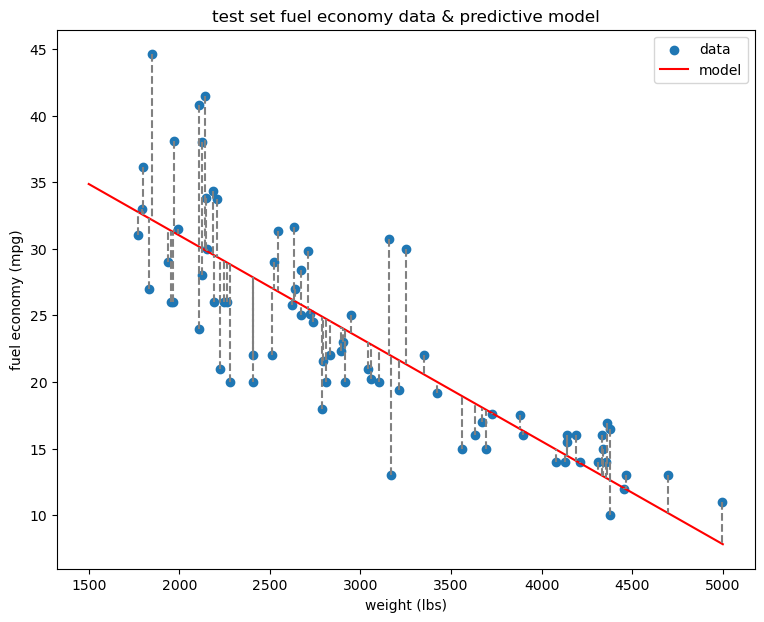

In [19]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.scatter(cars_test.weight, cars_test.mpg, label="data")
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("test set fuel economy data & predictive model")

weights = np.linspace(1500, 5000)
ax.plot(weights, fhat(weights), c="red", label="model")
ax.legend()

for x_i, y_i in zip(cars_test.weight, cars_test.mpg):
    plt.plot([x_i, x_i], [y_i, m*x_i+b], color='gray', linestyle='dashed')


In [20]:
yhat = fhat(cars_test.weight)
mse = ((cars_test.mpg - yhat)**2).mean()
print(mse)
rmse = np.sqrt(mse)
print(rmse)


20.233704522903235
4.498189027031127


We've halved our RMSE, a stunning success using linear regression!


## Linear regression on multiple predictors

As a notational convenience we coined:

$$\hat{y} = X\beta$$

We can generalize $X$ to a n by p+1 matrix, where row i corresponds to the ith sample, and column j corresponds to the jth predictor. Likewise $\beta$ is a vector of length p+1.

If we crack this open, it expands to:

$$ \hat{y*i} = \beta_0 \cdot 1 + \beta_1x*{i,1} + \beta*2x*{i,2} + ... + \beta*px*{i,p} $$

For example,

- 0th column would be all 1s,
- the 1st column of X holds the car weight,
- the 2st column of X holds the cylinder displacement.

In this case the semantics of $\beta$ is:

- $\beta_0$ is the "base" car mpg
- $\beta_1$ is the mpg penalty for each pound of car
- $\beta_2$ is the mpg penalty for each cc of engine displacement

Let's trust the math and try it:


In [21]:
X = np.stack([np.ones_like(cars_train.weight),
              cars_train.weight.values,
              cars_train.displacement.values]).T
y = cars_train.mpg.values


In [22]:
X[:10]


array([[1.000e+00, 2.045e+03, 9.800e+01],
       [1.000e+00, 1.945e+03, 8.500e+01],
       [1.000e+00, 3.430e+03, 2.250e+02],
       [1.000e+00, 2.200e+03, 1.050e+02],
       [1.000e+00, 3.012e+03, 2.000e+02],
       [1.000e+00, 2.278e+03, 1.130e+02],
       [1.000e+00, 4.425e+03, 4.550e+02],
       [1.000e+00, 3.420e+03, 2.600e+02],
       [1.000e+00, 2.545e+03, 1.190e+02],
       [1.000e+00, 2.615e+03, 1.190e+02]])

In [23]:
beta = np.linalg.inv(X.T @ X) @ X.T @ y  # the closed-form OLS solution
beta


array([ 4.45024213e+01, -6.20848786e-03, -1.32975132e-02])

In [24]:
X_test = np.stack([np.ones_like(cars_test.weight),
                   cars_test.weight.values,
                   cars_test.displacement.values]).T
y_test = cars_test.mpg.values


In [25]:
mse = ((X_test @ beta - y_test)**2).mean()
rmse = np.sqrt(mse)
print(mse)
print(rmse)


19.394298320210208
4.403895811688806


Adding displacement improves performance yet again.


## Linear regression using categorical predictors

In the cars dataset, the feature `origin` corresponds to the _continent_ or origin.


In [28]:
cars.origin.value_counts()


1    245
3     79
2     68
Name: origin, dtype: int64

This looks like a numerical feature, but it isn't at all - the codes correspond to the USA, Europe, and Asia in increasing order. How do we use the tools of linear regression on a feature that's _not a number_?

One simple strategy is to create numerical "dummy variables" that encode the presence of a categorical feature with a 1.0.


In [29]:
cars["american"] = cars.origin.map(lambda x: 1.0 if x == 1 else 0.0)
cars["european"] = cars.origin.map(lambda x: 1.0 if x == 2 else 0.0)
cars["asian"] = cars.origin.map(lambda x: 1.0 if x == 3 else 0.0)


In [30]:
cars.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name,american,european,asian
146,28.0,4,90.0,75.0,2125.0,14.5,74,1,dodge colt,1.0,0.0,0.0
282,22.3,4,140.0,88.0,2890.0,17.3,79,1,ford fairmont 4,1.0,0.0,0.0
69,12.0,8,350.0,160.0,4456.0,13.5,72,1,oldsmobile delta 88 royale,1.0,0.0,0.0
378,38.0,4,105.0,63.0,2125.0,14.7,82,1,plymouth horizon miser,1.0,0.0,0.0
331,33.8,4,97.0,67.0,2145.0,18.0,80,3,subaru dl,0.0,0.0,1.0


Now there exists a linear relationship between the category-dummy and the
target variable. For example as a car's "american" property goes to 1.0,
the fuel economy goes down:


Text(0, 0.5, 'fuel economy (mpg)')

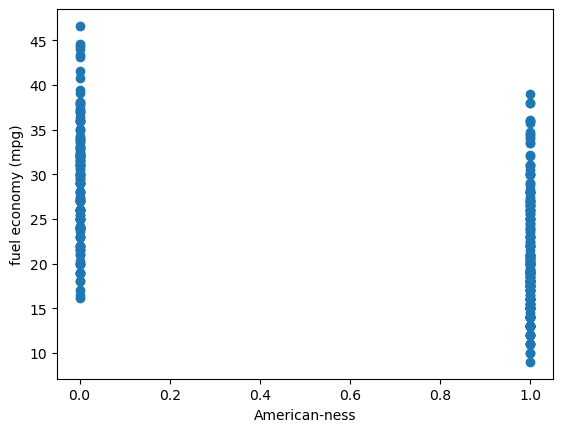

In [31]:
plt.scatter(cars.american, cars.mpg)
plt.xlabel("American-ness")
plt.ylabel("fuel economy (mpg)")


In [32]:
# note only using "American or not" in model below
cars_test = cars.iloc[:n_holdout]
cars_train = cars.iloc[n_holdout:]

X = np.stack([np.ones_like(cars_train.weight),
              cars_train.weight.values,
              cars_train.displacement.values,
              cars_train.american.values]).T
y = cars_train.mpg.values

beta = np.linalg.inv(X.T @ X) @ X.T @ y

X_test = np.stack([np.ones_like(cars_test.weight),
                   cars_test.weight.values,
                   cars_test.displacement.values,
                   cars_test.american.values]).T
y_test = cars_test.mpg.values

mse = ((X_test @ beta - y_test)**2).mean()
print(mse)
rmse = np.sqrt(mse)
print(rmse)


18.82363367825335
4.338621172475577


Once again we were able to squeak out a small improvement on the test set.


## Engineered features: making curves out of straight lines

The relationship between weight and fuel economy is _not a straight line_. This makes sense if you think about it: the fuel economy of a car can never be negative - it will go to zero as the weight increases.


Text(0.5, 1.0, 'car weight vs. fuel economy')

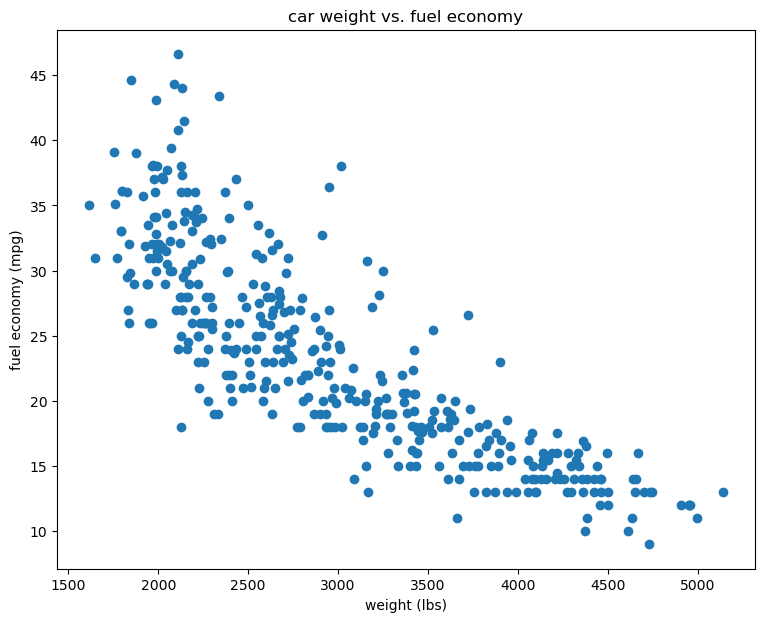

In [33]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.scatter(cars.weight, cars.mpg)
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("car weight vs. fuel economy")


One solution is to perform linear regression on engineered features. One potential model:

$$y = \beta_0 + \frac{\beta_1}{x_{weight}}$$

might seem nonlinear, but it's simply a linear function of the predictor $\frac{1}{x_{weight}}$.


Text(0.5, 1.0, 'car weight vs. fuel economy')

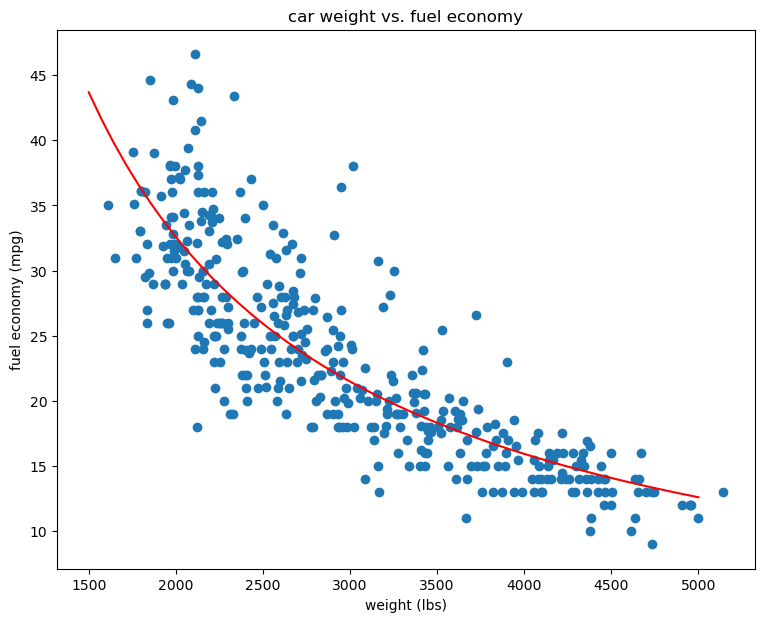

In [34]:
X = np.stack([np.ones_like(cars_train.weight),
              1/cars_train.weight.values]).T
y = cars_train.mpg.values

beta = np.linalg.inv(X.T @ X) @ X.T @ y
beta

fig, ax = plt.subplots(figsize=(9, 7))
ax.scatter(cars.weight, cars.mpg)
weightspace = np.linspace(1500, 5000)
ax.plot(weightspace, beta[1]*(1/weightspace)+beta[0], c="red")
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("car weight vs. fuel economy")


In [35]:
X_test = np.stack([np.ones_like(cars_test.weight),
                   1/cars_test.weight.values]).T
y_test = cars_test.mpg.values


mse = ((X_test @ beta - y_test)**2).mean()
print(mse)
rmse = np.sqrt(mse)
print(rmse)


19.913159670948602
4.462416348902083


One popular strategy for fitting complex curves is **polynomial regression**, which involves creating polynomial features from observed features.


Text(0.5, 1.0, 'car weight vs. fuel economy')

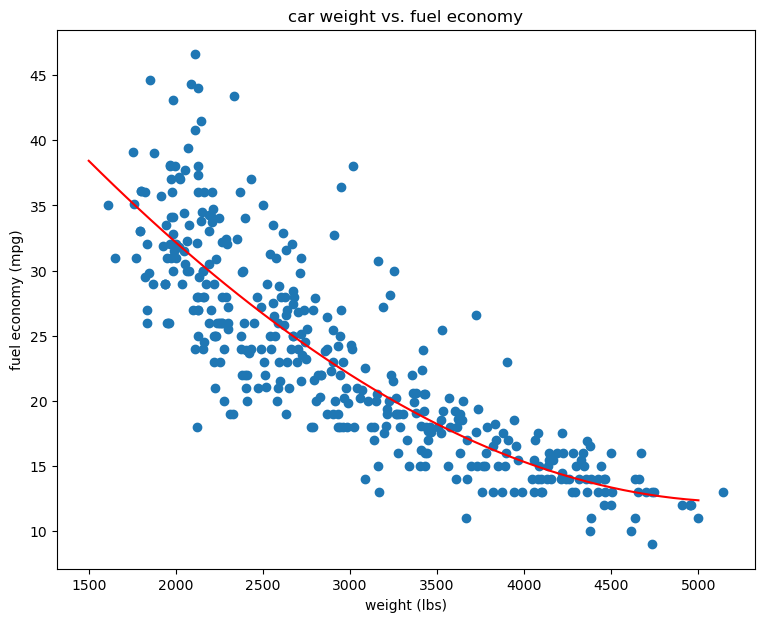

In [36]:
# going up to cubic features

X = np.stack([np.ones_like(cars_train.weight),
              cars_train.weight.values**1,
              cars_train.weight.values**2,
              cars_train.weight.values**3]).T
y = cars_train.mpg.values

beta = np.linalg.inv(X.T @ X) @ X.T @ y

fig, ax = plt.subplots(figsize=(9, 7))
ax.scatter(cars.weight, cars.mpg)
weightspace = np.linspace(1500, 5000)
fake_feats = np.stack([np.ones_like(weightspace),
                       weightspace**1,
                       weightspace**2,
                       weightspace**3]).T
ax.plot(weightspace, fake_feats @ beta, c="red")
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("car weight vs. fuel economy")


#### Question: which do you think is a preferable featurization in this case? 1/weight or polynomial approach?


## Cross-validation for hyperparameter selection


It is possible to go overboard with polynomial features, leading to poor generalization on the test set:


Text(0.5, 1.0, 'car weight vs. fuel economy')

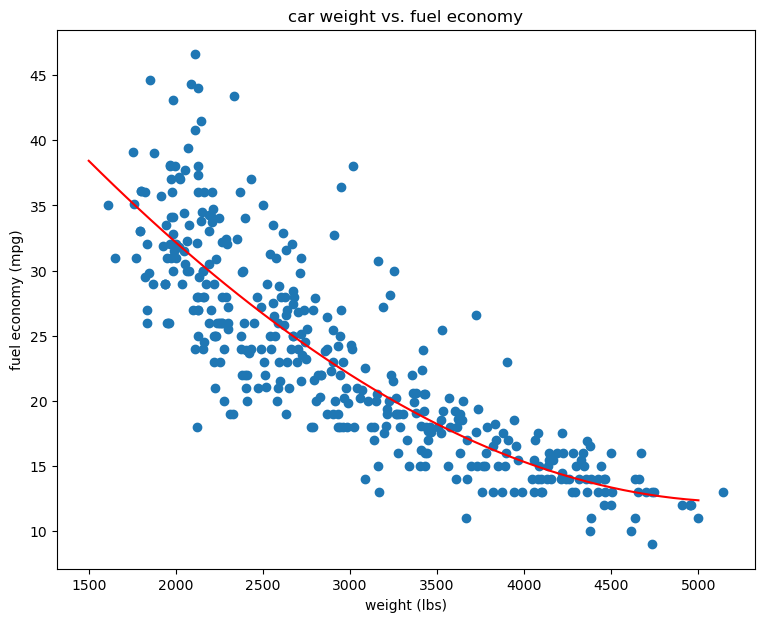

In [37]:
order = 3  # try 3, 5, 8, 10

features = [np.ones_like(cars_train.weight)]
for i in range(1, order+1):
    features.append(cars_train.weight.values**i)
X = np.stack(features).T
y = cars_train.mpg.values

beta = np.linalg.inv(X.T @ X) @ X.T @ y

fig, ax = plt.subplots(figsize=(9, 7))
ax.scatter(cars.weight, cars.mpg)
weightspace = np.linspace(1500, 5000)
fake_feats = [np.ones_like(weightspace)]
for i in range(1, order+1):
    fake_feats.append(weightspace**i)
fake_feats = np.stack(fake_feats).T
ax.plot(weightspace, fake_feats @ beta, c="red")
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("car weight vs. fuel economy")


Text(0.5, 1.0, 'Polynomial out of sample error')

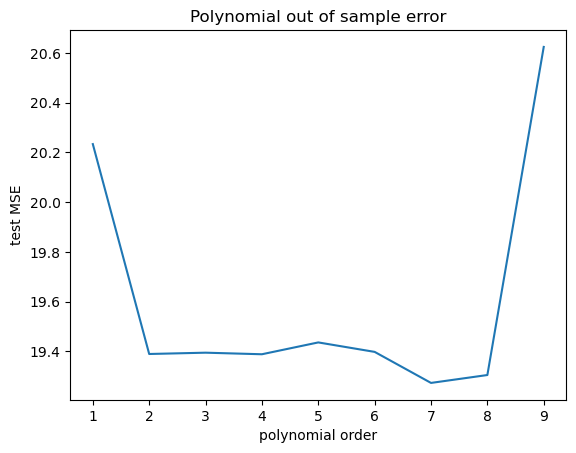

In [38]:
orders = range(1, 10)
mses = []
for order in orders:

    features = [np.ones_like(cars_train.weight)]
    for i in range(1, order+1):
        features.append(cars_train.weight.values**i)
    X = np.stack(features).T
    y = cars_train.mpg.values

    beta = np.linalg.inv(X.T @ X) @ X.T @ y

    features = [np.ones_like(cars_test.weight)]
    for i in range(1, order+1):
        features.append(cars_test.weight.values**i)
    X_test = np.stack(features).T

    test_mse = ((X_test @ beta - y_test)**2).mean()
    mses.append(test_mse)

plt.plot(orders, mses)
plt.xlabel("polynomial order")
plt.ylabel("test MSE")
plt.title("Polynomial out of sample error")


## In practice: linear regression using `sklearn`

Mostly we just use helper functions to do all of this:


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


Put together feature matrix and target vector


In [40]:
X = cars[["cylinders", "displacement", "horsepower", "weight",
          "acceleration", "american", "european", "asian"]]
y = cars["mpg"]


Do train test split


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


Fit using training set.


In [42]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

Predict using the test features.


In [43]:
yhat = model.predict(X_test)


Evaluate against the test target.


In [44]:
mse = mean_squared_error(y_test, yhat)
print(mse)
rmse = np.sqrt(mse)
print(rmse)


16.53233502236502
4.065997420358874


^ The best yet. This model "wins" based on performance, but what influences mpg the most? Ah, if you care about that you're in the wrong place! What you want is inferential regression (and that's next).


## Jumping ahead: inference

Some assumptions that must hold in order to use linear regression for _inference_.


### Linearity: violated when you see nonlinear trends in your data / residuals


### Homoscedasticity: violated when the variance of your residuals isn't constant


### Normality: violated when the residuals are not normally distributed


### Multicollinearity: strictly violated when one feature is a linear combination of others, loosely violated when one feature is highly correlated with others
